In [56]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numba import njit
from matplotlib.animation import FuncAnimation

In [ ]:
G = 6.67430e-11

In [51]:
def initialize_solar_system():
    masses = np.array([
        1.989e30,   # Солнце
        3.30e23,    # Меркурий
        4.87e24,    # Венера
        5.97e24,    # Земля
        6.42e23,    # Марс
        1.90e27,    # Юпитер
        5.68e26,    # Сатурн
        8.68e25,    # Уран
        1.02e26     # Нептун
    ])
    
    positions = np.array([
        [0.0, 0.0],                   # Солнце
        [5.79e10, 0.0],               # Меркурий
        [1.08e11, 0.0],               # Венера
        [1.496e11, 0.0],              # Земля
        [2.28e11, 0.0],               # Марс
        [7.78e11, 0.0],               # Юпитер
        [1.43e12, 0.0],               # Сатурн
        [2.87e12, 0.0],               # Уран
        [4.50e12, 0.0]                # Нептун
    ])
    
    '''velocities = np.array([
        [0.0, 0.0],                   # Солнце
        [0.0, 47400.0],               # Меркурий
        [0.0, 35000.0],               # Венера
        [0.0, 29780.0],               # Земля
        [0.0, 24100.0],               # Марс
        [0.0, 13070.0],               # Юпитер
        [0.0, 9680.0],                # Сатурн
        [0.0, 6800.0],                # Уран
        [0.0, 5430.0]                 # Нептун
    ])'''
    
    velocities = np.array([
    [0.0, 0.0],                    # Солнце
    [0.0, 47400.0 * 0.9],          # Меркурий (снижаем на 10%)
    [0.0, 35000.0 * 0.95],         # Венера
    [0.0, 29780.0],                # Земля (оставим как есть)
    [0.0, 24100.0 * 1.05],         # Марс (чуть быстрее)
    [0.0, 13070.0 * 0.97],         # Юпитер
    [0.0, 9680.0 * 1.03],          # Сатурн
    [0.0, 6800.0 * 0.85],          # Уран (сильно меняем)
    [0.0, 5430.0 * 1.1]            # Нептун
])
    
    return masses, positions, velocities

In [ ]:
def n_body_rhs(t, y, masses, G=6.67430e-11):
    n = len(masses)
    positions = y[:2 * n].reshape((n, 2))
    velocities = y[2 * n:].reshape((n, 2))
    
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_ij = positions[j] - positions[i]
                dist = np.linalg.norm(r_ij) + 1e-10
                accelerations[i] += G * masses[j] * r_ij / dist**3
    
    dydt = np.concatenate((velocities.flatten(), accelerations.flatten()))
    return dydt

In [ ]:
def run_solve_ivp(masses, pos0, vel0, t_span, t_eval):
    y0 = np.concatenate((pos0.flatten(), vel0.flatten()))
    sol = solve_ivp(
        fun=lambda t, y: n_body_rhs(t, y, masses),
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        rtol=1e-9,
        atol=1e-9,
        method='RK45'
    )
    n = len(masses)
    positions = sol.y[:2 * n].reshape(n, 2, -1)
    return positions

In [ ]:
def velocity_verlet(masses, positions, velocities, dt, steps):
    N = len(masses)
    traj = np.zeros((N, 2, steps))
    traj[:, :, 0] = positions
    pos = positions.copy()
    vel = velocities.copy()

    def compute_acc(pos):
        acc = np.zeros_like(pos)
        for i in range(N):
            for j in range(N):
                if i != j:
                    r = pos[j] - pos[i]
                    dist = np.linalg.norm(r) + 1e-10
                    acc[i] += G * masses[j] * r / dist**3
        return acc

    acc = compute_acc(pos)
    for t in range(1, steps):
        pos += vel * dt + 0.5 * acc * dt**2
        new_acc = compute_acc(pos)
        vel += 0.5 * (acc + new_acc) * dt
        acc = new_acc
        traj[:, :, t] = pos
    return traj

In [ ]:
@njit
def velocity_verlet_numba(masses, positions, velocities, dt, steps):
    N = len(masses)
    traj = np.zeros((N, 2, steps))
    traj[:, :, 0] = positions
    pos = positions.copy()
    vel = velocities.copy()
    acc = np.zeros((N, 2))
    
    for i in range(N):
        for j in range(N):
            if i != j:
                r = positions[j] - positions[i]
                dist = np.sqrt(np.sum(r**2)) + 1e-10
                acc[i] += G * masses[j] * r / dist**3

    for t in range(1, steps):
        pos += vel * dt + 0.5 * acc * dt**2
        new_acc = np.zeros_like(acc)
        for i in range(N):
            for j in range(N):
                if i != j:
                    r = pos[j] - pos[i]
                    dist = np.sqrt(np.sum(r**2)) + 1e-10
                    new_acc[i] += G * masses[j] * r / dist**3
        vel += 0.5 * (acc + new_acc) * dt
        acc = new_acc
        traj[:, :, t] = pos
    return traj

In [ ]:
def compute_errors(reference, test):
    min_len = min(reference.shape[2], test.shape[2])
    return np.linalg.norm(reference[:, :, :min_len] - test[:, :, :min_len], axis=1).mean(axis=0)

In [ ]:
def plot_trajectories(trajs, labels):
    planet_names = [
        "Солнце", "Меркурий", "Венера", "Земля", "Марс",
        "Юпитер", "Сатурн", "Уран", "Нептун"
    ]
    colors = [
        'orange', 'gray', 'gold', 'blue', 'red',
        'brown', 'khaki', 'lightblue', 'darkblue'
    ]
    
    for traj, method_label in zip(trajs, labels):
        plt.figure(figsize=(8, 8))
        for i in range(traj.shape[0]):
            x = traj[i, 0]
            y = traj[i, 1]
            plt.plot(x, y, label=planet_names[i], color=colors[i % len(colors)])
            plt.text(x[-1], y[-1], planet_names[i], fontsize=8, color=colors[i % len(colors)])
        
        plt.title(f'Траектории тел: {method_label}')
        plt.xlabel('X (м)')
        plt.ylabel('Y (м)')
        plt.legend(loc='upper right', fontsize=8)
        plt.axis('equal')
        plt.grid()
        plt.tight_layout()
        plt.show()

def plot_errors(errors_dict, t_eval):
    plt.figure(figsize=(10, 5))
    for name, err in errors_dict.items():
        plt.plot(t_eval, err, label=name)
    plt.title('Погрешности по сравнению с solve_ivp')
    plt.xlabel('Время (с)')
    plt.ylabel('Ошибка (м)')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def main():
    masses, pos0, vel0 = initialize_solar_system()
    T = 30 * 365 * 24 * 3600
    steps = 1000
    dt = T / (steps - 1)
    t_eval = np.linspace(0, T, steps)

    sol_ivp = run_solve_ivp(masses, pos0, vel0, (0, T), t_eval)
    traj_verlet = velocity_verlet(masses, pos0, vel0, dt, steps)
    traj_numba = velocity_verlet_numba(masses, pos0, vel0, dt, steps)

    plot_trajectories([sol_ivp, traj_verlet, traj_numba], ['solve_ivp', 'Верле', 'Верле + Numba'])

    errors = {
        'Верле': compute_errors(sol_ivp, traj_verlet),
        'Верле + Numba': compute_errors(sol_ivp, traj_numba)
    }

    plot_errors(errors, t_eval)

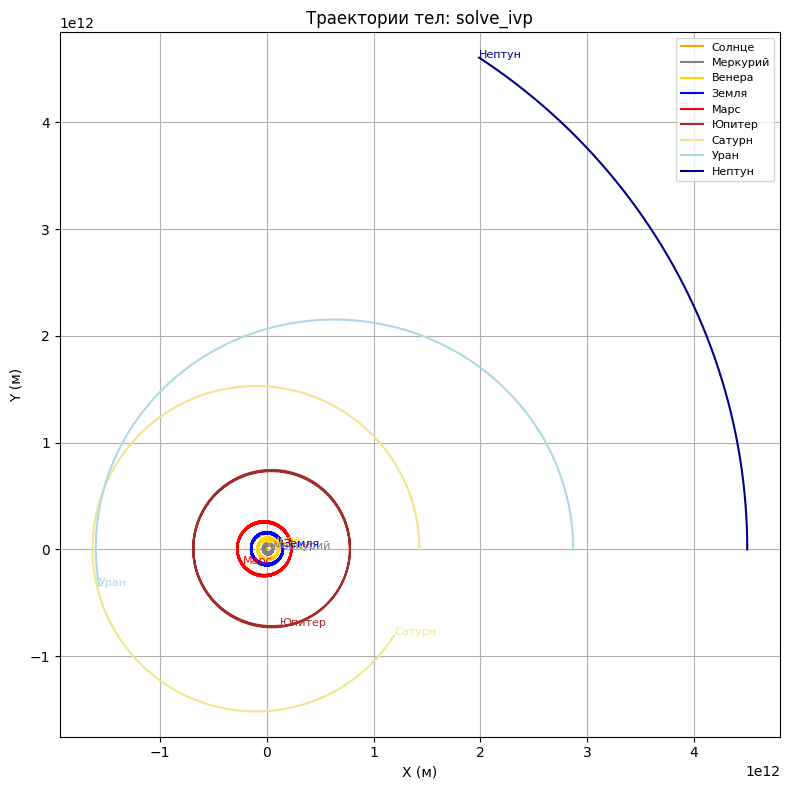

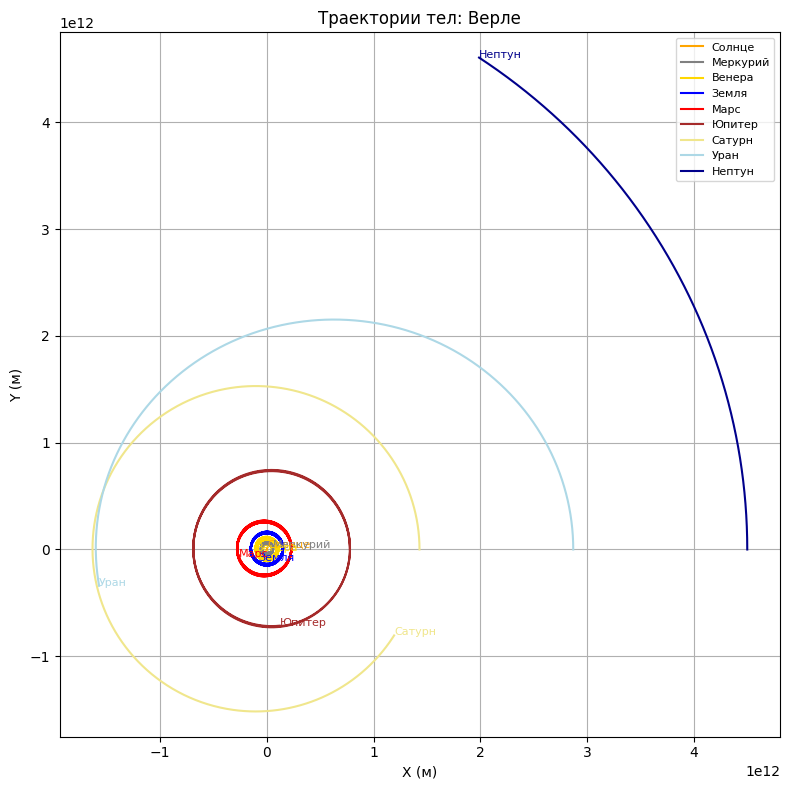

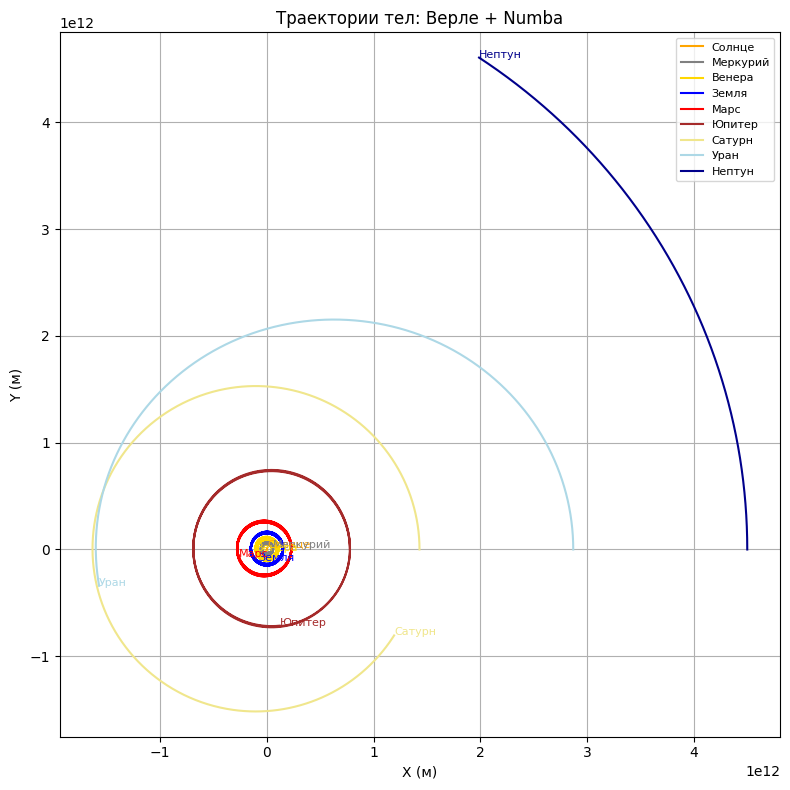

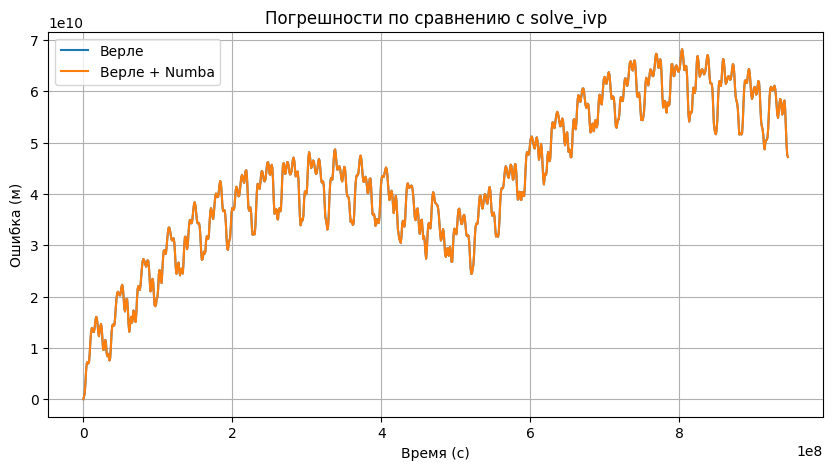

In [55]:
main()

In [60]:
def save_animation(trajectories, filename='planets.gif', interval=20):
    n_bodies, _, n_steps = trajectories.shape
    planet_names = [
        "Солнце", "Меркурий", "Венера", "Земля", "Марс",
        "Юпитер", "Сатурн", "Уран", "Нептун"
    ]
    colors = [
        'orange', 'gray', 'gold', 'blue', 'red',
        'brown', 'khaki', 'lightblue', 'darkblue'
    ]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    lines = [ax.plot([], [], 'o', color=colors[i], label=planet_names[i])[0] for i in range(n_bodies)]
    trails = [ax.plot([], [], '-', lw=0.5, color=colors[i])[0] for i in range(n_bodies)]

    ax.set_xlim(-5e12, 5e12)
    ax.set_ylim(-5e12, 5e12)
    ax.set_aspect('equal')
    ax.set_title('Движение планет (solve_ivp)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid()

    def init():
        for line, trail in zip(lines, trails):
            line.set_data([], [])
            trail.set_data([], [])
        return lines + trails

    def update(frame):
        for i in range(n_bodies):
            x = trajectories[i, 0, :frame]
            y = trajectories[i, 1, :frame]
            lines[i].set_data(x[-1:], y[-1:])
            trails[i].set_data(x, y)
        return lines + trails

    ani = FuncAnimation(fig, update, frames=n_steps, init_func=init,
                        blit=True, interval=interval)
    
    ani.save(filename, writer='pillow')
    print(f"Анимация сохранена как {filename}")

Анимация сохранена как solar_system_2.gif


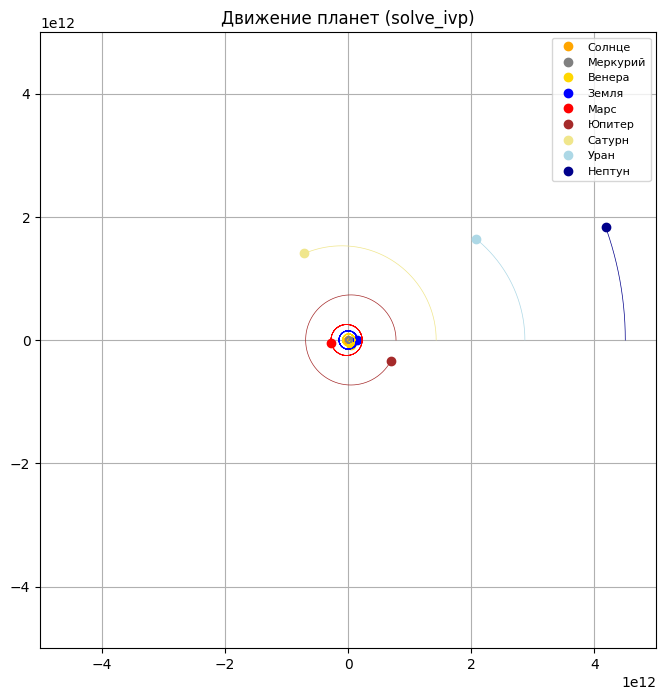

In [61]:
masses, pos0, vel0 = initialize_solar_system()
T = 10 * 365 * 24 * 3600  # 1 год
steps = 1000
dt = T / (steps - 1)
t_eval = np.linspace(0, T, steps)

sol_ivp = run_solve_ivp(masses, pos0, vel0, (0, T), t_eval)
save_animation(sol_ivp, 'solar_system_2.gif')

In [ ]:
def save_log_scale_animation(trajectories, filename='planets_log_scale.gif', interval=20):
    n_bodies, _, n_steps = trajectories.shape
    planet_names = [
        "Солнце", "Меркурий", "Венера", "Земля", "Марс",
        "Юпитер", "Сатурн", "Уран", "Нептун"
    ]
    colors = [
        'orange', 'gray', 'gold', 'blue', 'red',
        'brown', 'khaki', 'lightblue', 'darkblue'
    ]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    lines = [ax.plot([], [], 'o', color=colors[i], label=planet_names[i])[0] for i in range(n_bodies)]
    trails = [ax.plot([], [], '-', lw=0.5, color=colors[i])[0] for i in range(n_bodies)]

    ax.set_aspect('equal')
    ax.set_title('Движение планет (solve_ivp)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid()

    def init():
        for line, trail in zip(lines, trails):
            line.set_data([], [])
            trail.set_data([], [])
        return lines + trails

    def update(frame):
        for i in range(n_bodies):
            x = trajectories[i, 0, :frame]
            y = trajectories[i, 1, :frame]
            
            log_x = np.log10(np.abs(x) + 1e-10)
            log_y = np.log10(np.abs(y) + 1e-10)

            lines[i].set_data(log_x[-1:], log_y[-1:])
            trails[i].set_data(log_x, log_y)
        return lines + trails
    
    ax.set_xlim(np.log10(1e7), np.log10(1e12))
    ax.set_ylim(np.log10(1e7), np.log10(1e12))

    ani = FuncAnimation(fig, update, frames=n_steps, init_func=init,
                        blit=True, interval=interval)
    
    ani.save(filename, writer='pillow')
    print(f"Анимация сохранена как {filename}")

Анимация сохранена как planets_log_scale.gif


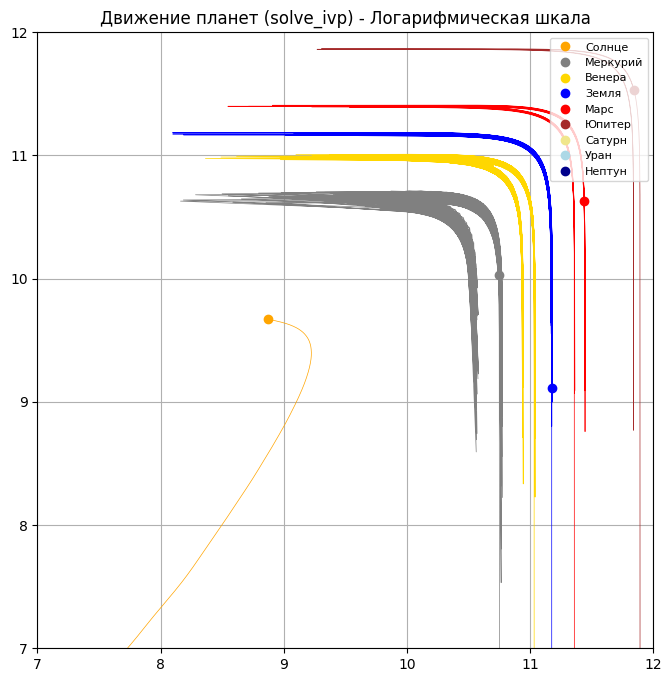

In [63]:
sol_ivp = run_solve_ivp(masses, pos0, vel0, (0, T), t_eval)
save_log_scale_animation(sol_ivp, 'planets_log_scale.gif')